In [1]:
%matplotlib notebook

from sdss import SDSS
import mikkel_tools.utility as mt_util

import numpy as np
from math import inf
from scipy.optimize import curve_fit
import scipy as sp
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import time
import pyshtools
import pickle

comment = "Generate simple example with fisher func"
nb_name = "nb_seqsim_simple_ex_fisher_TI_based"
shn = 20
glq_r = 1

# SH power
degrees = np.arange(1,22, dtype=float)
power = np.flip(degrees**(-1))
power = np.hstack((0,np.ones(20)))

# Generate surface truth object
surface_t = SDSS(comment, N_SH = shn, sim_type = "core")
surface_t.grid_glq(nmax = shn, r_at = glq_r)
grid_in = np.array([surface_t.grid_phi, 90-surface_t.grid_theta]).T
surface_t.make_grid(glq_r, grid_in, calc_sph_d = True)
# Get random surface based on int seed
rand_int = 67803
clm = pyshtools.SHCoeffs.from_random(power, seed=rand_int)
grid = clm.expand()
coeffs = clm.to_array(lmax=shn)
# Set data from random SH coeffs
surface_t.data = pyshtools.expand.MakeGridGLQ(coeffs, surface_t.grid_zero, [surface_t.grid_nmax, 1, 1, shn, False]).reshape(-1,)
surface_t.target_var = np.var(surface_t.data)
surface_t.target_mean = 0.0
surface_t.g_prior, surface_t.g_prior_cilm = mt_util.sh_expand_glq(surface_t.data, 
                             surface_t.grid_nmax, surface_t.grid_w_shtools, surface_t.grid_zero, 
                             shn, geomag_scale = False)

# Load surface object
file_pickle = open("{}_conditional.obj".format(nb_name), 'rb')
surface = pickle.load(file_pickle)
file_pickle.close()
#surface.grid_glq(nmax = shn, r_at = glq_r)
#grid_in = np.array([surface.grid_phi, 90-surface.grid_theta]).T
#surface.make_grid(glq_r, grid_in, calc_sph_d = False)
#surface.generate_map()

# Load surface_uncon object
file_pickle = open("{}_unconditional.obj".format(nb_name), 'rb')
surface_uncon = pickle.load(file_pickle)
file_pickle.close()
#surface_uncon.grid_glq(nmax = shn, r_at = glq_r)
#grid_in = np.array([surface_uncon.grid_phi, 90-surface_uncon.grid_theta]).T
#surface_uncon.make_grid(glq_r, grid_in, calc_sph_d = False)
#surface_uncon.generate_map()

# Load s_obs
file_pickle = open("{}_randobs.obj".format(nb_name), 'rb')
s_obs = pickle.load(file_pickle)
file_pickle.close()

In [2]:
print(surface)


______current attributes______

a:                     6371.2
r_sat:                 6721.2
r_cmb:                 3480.0
rad:                   0.017453292519943295
mu0:                   1.2566370614359173e-06
comment:               Generate simple example with fisher func
class_abs_path:        /home/mikotz/spherical_direct_sequential_simulation
N_SH:                  20
N_SH_secondary:        None
sim_type:              core
grid_zero:             (21,), Max/Min: 0.99 / -0.99
grid_w_shtools:        (21,), Max/Min: 0.15 / 0.02
grid_shape:            (2,), Max/Min: 41.00 / 21.00
grid_w:                (861,), Max/Min: 0.15 / 0.02
grid_radial:           (861,), Max/Min: 1.00 / 1.00
grid_theta:            (861,), Max/Min: 173.59 / 6.41
grid_phi:              (861,), Max/Min: 351.22 / 0.00
grid_N:                861
grid_nmax:             20
r_grid:                1
grid:                  (861, 2)
sph_d:                 (861, 861)
lon:                   (861,), Max/Min: 351.22 / 0.00
l

# Check transform

In [6]:
C_vec, _ = mt_util.sh_expand_glq(surface.m_DSS[:,[0]], surface.grid_nmax, surface.grid_w_shtools, 
                                     surface.grid_zero, 20, geomag_scale = False)



g_0 = np.array(C_vec).T

m_DSS_shtools = mt_util.sh_makegrid_glq(g_0, surface.grid_nmax, surface.grid_zero, 30, set_norm = 1)
m_DSS_shtools.shape

(21, 41)

<IPython.core.display.Javascript object>


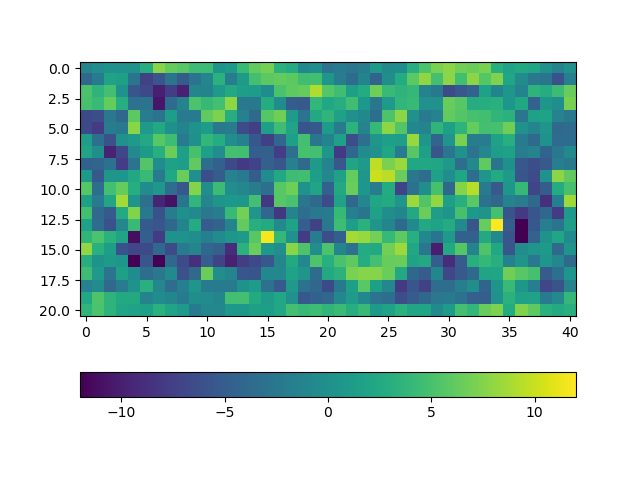

<IPython.core.display.Javascript object>


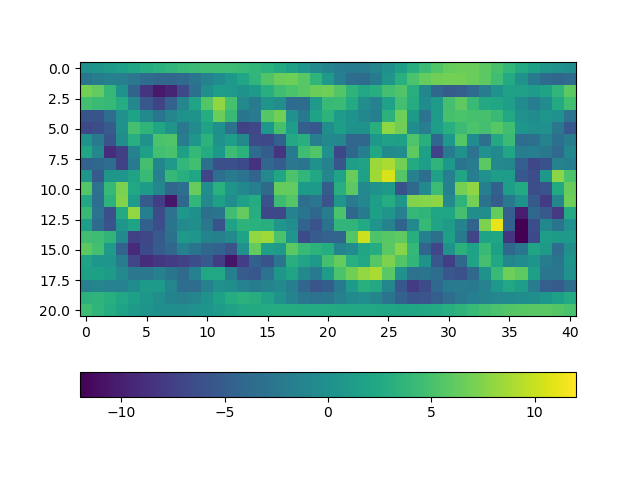

In [9]:
plt.figure()
plt.imshow(surface.m_DSS[:,0].reshape(21,41), vmin = -12, vmax = 12)
plt.colorbar(orientation='horizontal')
plt.show()

plt.figure()
plt.imshow(m_DSS_shtools, vmin = -12, vmax = 12)
plt.colorbar(orientation='horizontal')
plt.show()

In [11]:
C_e_const = 10**(-3)

theta_s, theta_d, phi_s, phi_d = map(np.radians, 
                                     [surface.grid_theta.reshape(1,-1), s_obs.grid_theta.reshape(-1,1), 
                                      surface.grid_phi.reshape(1,-1), s_obs.grid_phi.reshape(-1,1)])

angdist = np.arccos(np.cos(theta_d)*np.cos(theta_s)+np.multiply(np.sin(theta_d)@np.sin(theta_s),np.cos(phi_d-phi_s)))

kappa = 15
Tau = 1/s_obs.r_grid.reshape(-1,1)*kappa/(4*np.pi*np.sinh(kappa))*np.exp(kappa*np.cos(angdist))
Tau.shape

# Generate forward operator and covariances based on prior object
surface.G = np.pi/(surface.grid_nmax+0.5)*np.multiply(surface.grid_w,Tau) # +0.5 for parity with SHTOOLS

C_e = np.diag(C_e_const**2*np.ones(s_obs.N_grid,)) # No need to store C_e outside of here

surface.C_mm_all = surface.target_var-surface.sv_lut

surface.C_dm_all = surface.G@surface.C_mm_all

surface.C_dd = surface.C_dm_all@surface.G.T  + C_e

surface.C_dm_all = surface.C_dm_all.T

surface.C_e_const = C_e_const

<IPython.core.display.Javascript object>


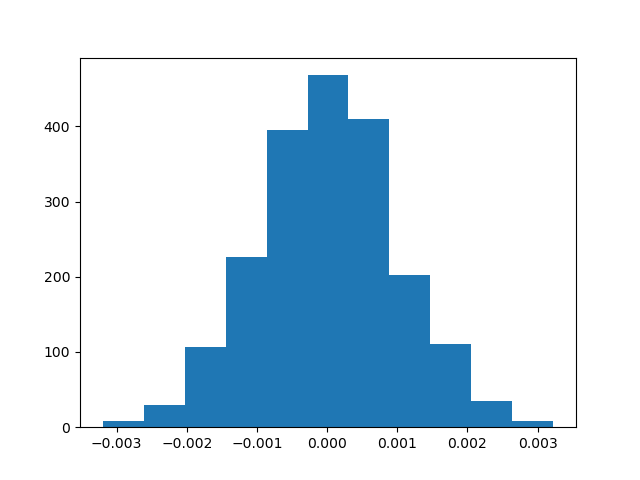

In [12]:
m_DSS_shtools_pred = surface.G@m_DSS_shtools.reshape(-1,1)
m_DSS_shtools_res = s_obs.data.reshape(-1,1) - m_DSS_shtools_pred

plt.figure()
plt.hist(m_DSS_shtools_res,bins=11)
plt.show()

# Results display

<IPython.core.display.Javascript object>


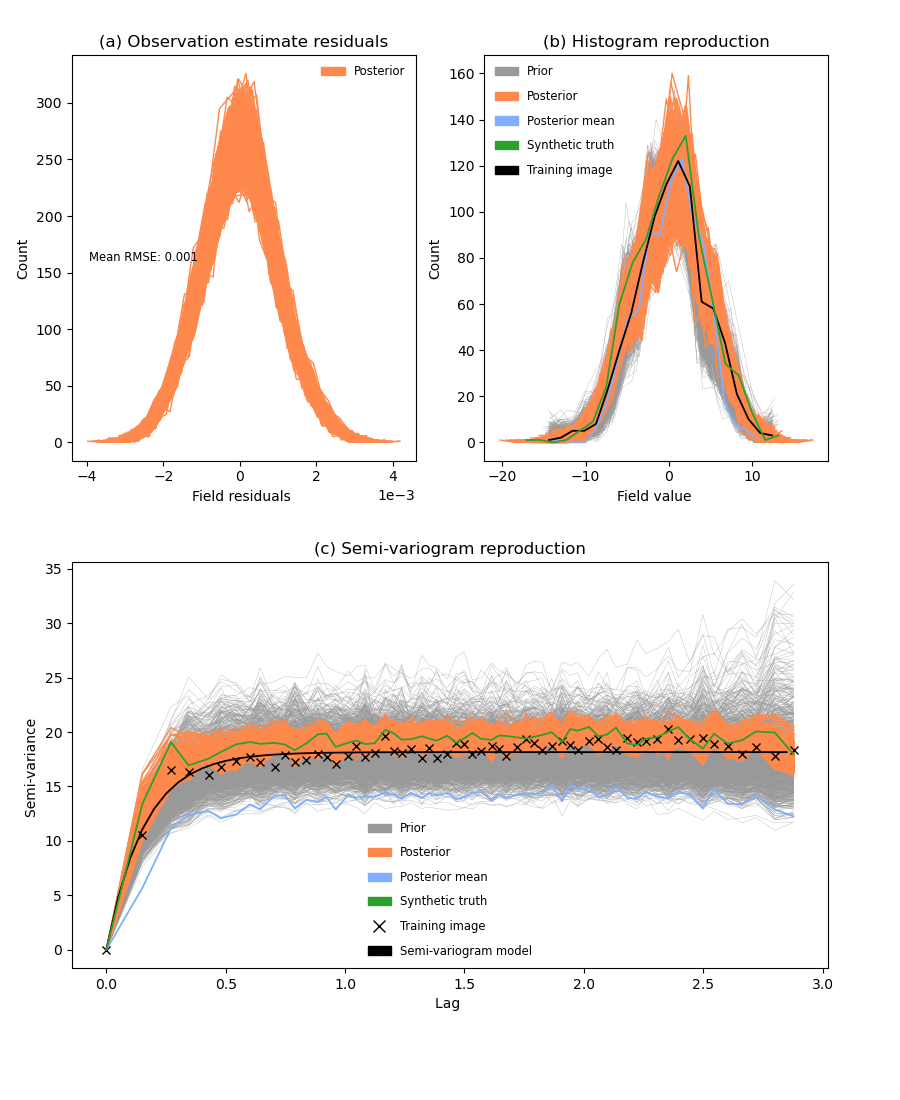

In [3]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

surface.grid_glq(nmax = shn, r_at = 1.0)
#surface.m_equiv_lsq
mt_util.plot_sdssim_reproduce(surface, surface.m_DSS_res, m_equiv_lsq = None,
                              lwidth = 1, lwidth_mult = 1.3, lwidth_div=5,
                              truth_obj = surface_t, uncon_obj = surface_uncon,
                              spec_r_at = 1.0, spec_use = False, spec_show_differences = False, spec_mag = False,
                              figsize=(9,11), hist_pos_mean = True, sv_pos_mean = True, lags_use = 1000,
                              unit_var = "", unit_lag = "", unit_field = "", unit_res = "",
                              hist_bins = 20, res_bins = 20, patch_legend = True,
                              res_power_format = True, power_limit = -3, res_print_f = 3,
                              savefig = False, save_string = "simple_ex_fisher", save_path = "images/", 
                              save_dpi = 100)

In [27]:
set_nmax = shn
r_at = 1.0

surface.grid_glq(nmax = 400, r_at = r_at)

# Posterior
zs_eqa = []
for i in np.arange(0,surface.g_spec.shape[1]):
    z_grid = mt_util.sh_makegrid_glq(surface.g_spec[:,i], surface.grid_nmax, surface.grid_zero, set_nmax)
    
    zs_eqa.append(z_grid.reshape(-1,))
zs_eqa = np.array(zs_eqa).T

# Unconditional posterior
zs_uncon = []
for i in np.arange(0,surface.g_spec.shape[1]):
    z_grid = mt_util.sh_makegrid_glq(surface_uncon.g_spec[:,i], surface.grid_nmax, surface.grid_zero, set_nmax)
    
    zs_uncon.append(z_grid.reshape(-1,))
zs_uncon = np.array(zs_uncon).T

# Posterior mean
zs_mean_eqa = mt_util.sh_makegrid_glq(surface.g_spec_mean, surface.grid_nmax, surface.grid_zero, set_nmax)

# Truth
prior_eqa = mt_util.sh_makegrid_glq(surface_t.g_prior[:mt_util.shc_vec_len(set_nmax)], surface.grid_nmax, surface.grid_zero, set_nmax)

# LSQ
lsq_eqa = mt_util.sh_makegrid_glq(surface.g_equiv_lsq, surface.grid_nmax, surface.grid_zero, set_nmax)

<IPython.core.display.Javascript object>


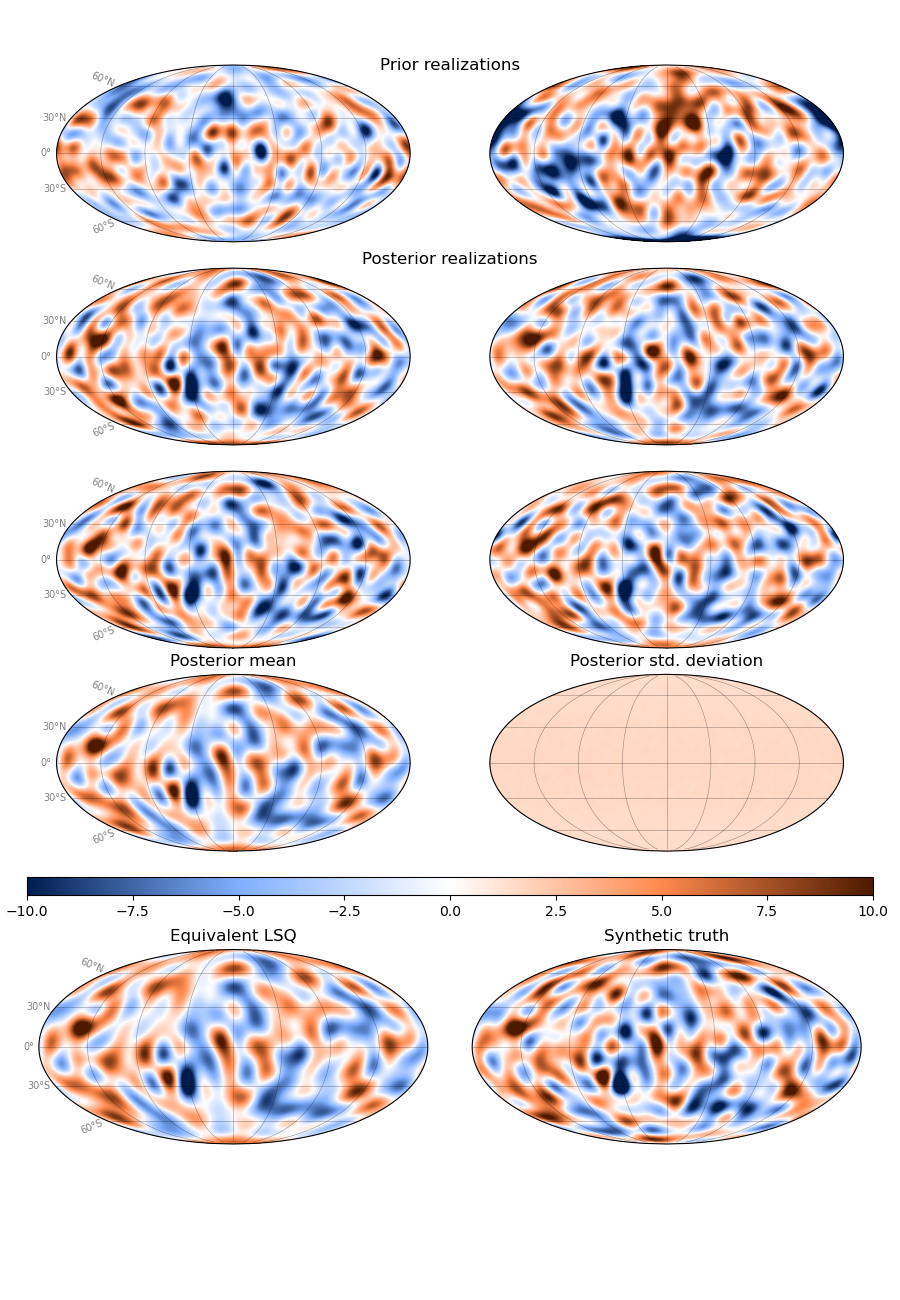

In [36]:
# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)
# ccrs.PlateCarree()
# ccrs.Mollweide()
# ccrs.Orthographic(central_longitude=0.0, central_latitude=0.0)

mt_util.plot_ensemble_map_tiles(surface.grid_phi, 90-surface.grid_theta, zs_eqa, field_uncon = zs_uncon,
                        field_compare = prior_eqa, field_lsq = lsq_eqa, field_mean = zs_mean_eqa,
                        tile_size_row = 4, tile_size_column = 2, 
                        figsize=(9,13), limit_for_SF = 10**6, point_size = 0.1, cbar_mm_factor = 1,
                        coast_width = 0.0, coast_color = "grey", unit_transform_n_to_m = False,
                        cbar_h = 0.1, cbar_text = "", cbar_text_color = "black", cbar_limit = [-10,10],
                        left=0.03, bottom=0.12, right=0.97, top=0.95, wspace = 0.05, hspace=0.2, 
                        savefig = False, save_string = "simple_ex_fisher", save_path = "images/",
                        projection = ccrs.Mollweide(), use_gridlines = True, 
                        gridlines_width = 0.4, gridlines_alpha = 0.4, save_dpi = 100)


# Local distribution map

In [20]:
surface.grid_glq(nmax = shn, r_at = 1.0)

skip = 1
m_skip = surface.m_DSS[:,:][0::skip]
lat_skip = surface.lat[0::skip]
lon_skip = surface.lon[0::skip]

N_bins = 51
m_centers = []
m_y = []
for i in np.arange(0,m_skip.shape[0]):
    y,binEdges=np.histogram(m_skip[i,:],bins=N_bins)
    bincenters = 0.5*(binEdges[1:]+binEdges[:-1])
    
    m_centers.append(bincenters)
    m_y.append(y)
m_centers = np.array(m_centers)
m_y = np.array(m_y)

deg_range = 1
lat_skip_lin = np.linspace(lat_skip-deg_range,lat_skip+deg_range,N_bins)
lon_skip_lin = np.linspace(lon_skip-1*deg_range,lon_skip+1*deg_range,N_bins)

m_y_scaled = []
for i in np.arange(0,m_skip.shape[0]):
    scale = np.min(lat_skip_lin[:,i]) + (m_y[i,:]-np.min(m_y[i,:]))*(np.max(lat_skip_lin[:,i])-np.min(lat_skip_lin[:,i]))/(np.max(m_y[i,:])-np.min(m_y[i,:]))
    m_y_scaled.append(scale)
m_y_scaled = np.array(m_y_scaled)

local_lat = m_y_scaled.reshape(-1,)
local_lon = lon_skip_lin.T.reshape(-1,)
local_data = m_centers.reshape(-1,)

# Reload plot module when making small changes
import importlib
importlib.reload(mt_util)

point_size = 3
color_bg = (0.6,0.6,0.6)
save_string_local = "simple_ex_fisher"
limits_data = [-10,10]

<IPython.core.display.Javascript object>


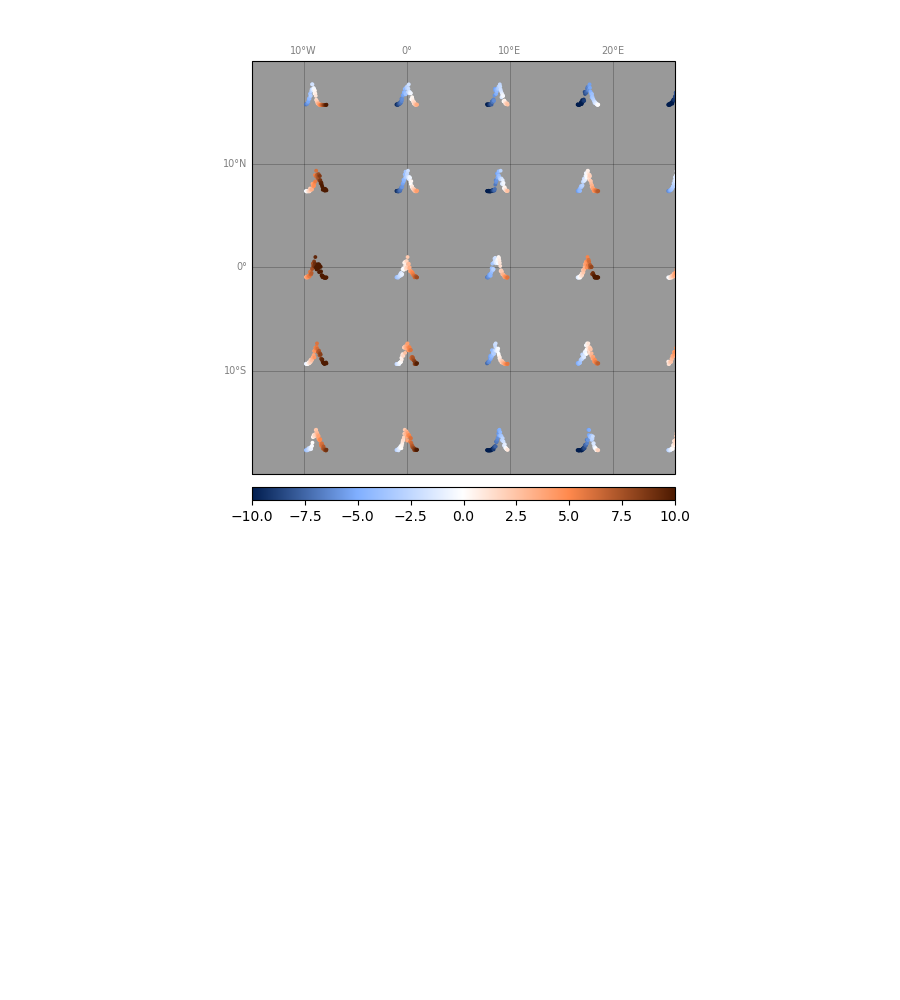

In [22]:
# West coast africa "cove"
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = limits_data,
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = False,
                cbar_text = "", figsize=(9,10), coast_width = 0.0,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.28, right = 0.75, extent = [-15, 26, -20, 20],
                title='', point_size=point_size, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string = save_string_local + "_wafrica",
                save_path = "images/", use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4,
                data_on_top = True, color_bg = color_bg)

<IPython.core.display.Javascript object>


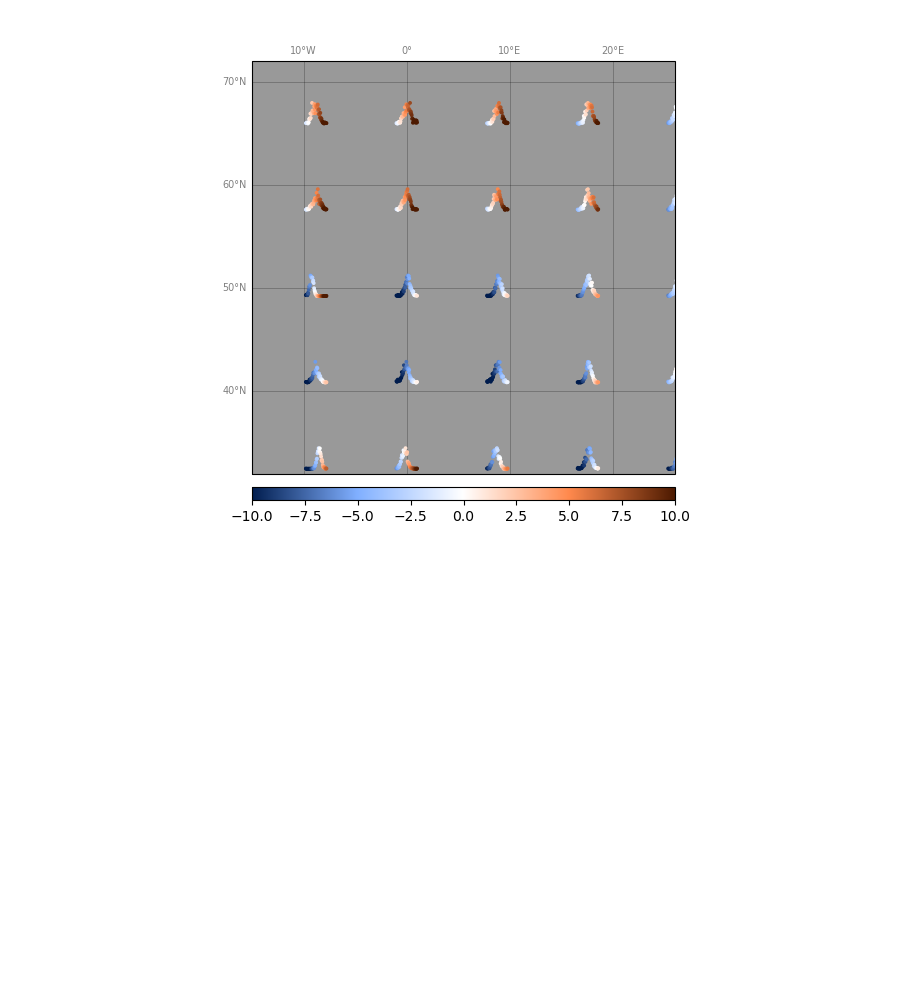

In [23]:
# EU
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = limits_data,
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = False,
                cbar_text = "", figsize=(9,10), coast_width = 0.0,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.28, right = 0.75, extent = [-15, 26, 32, 72],
                title='', point_size=point_size, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string = save_string_local + "_europe",
                save_path = "images/", use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4,
                data_on_top = True, color_bg = color_bg)

<IPython.core.display.Javascript object>


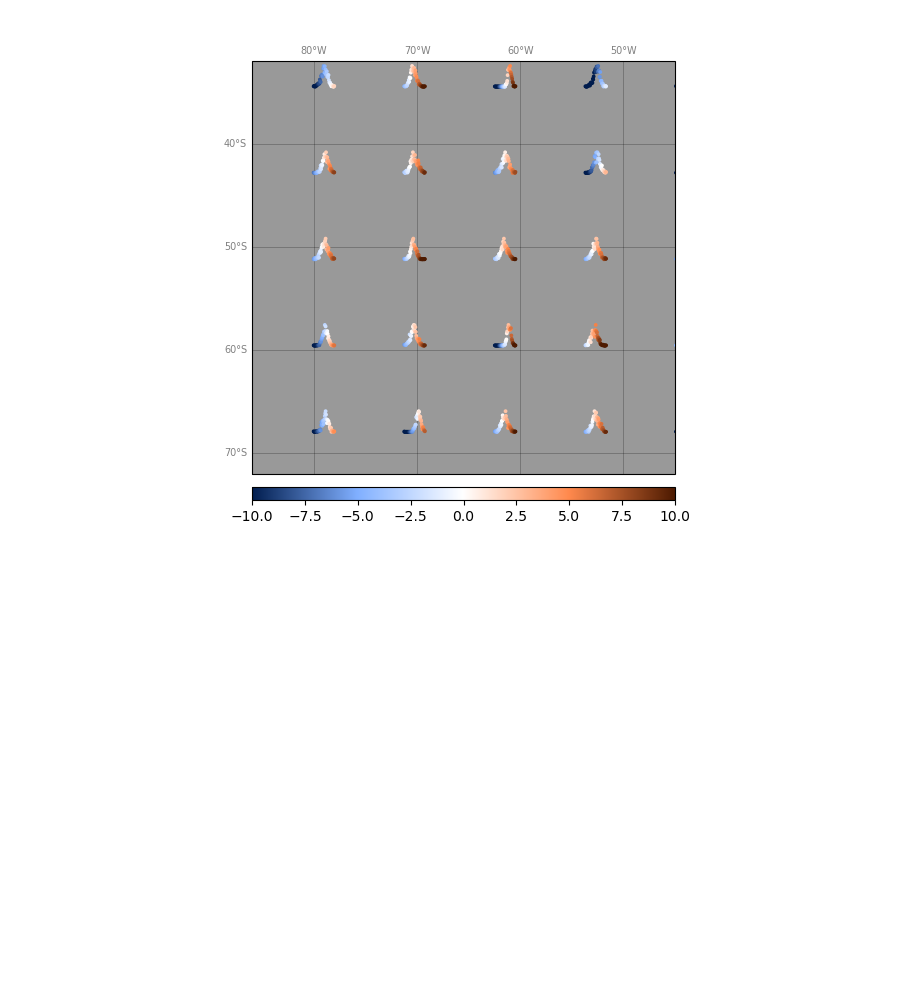

In [24]:
# South America tip
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = limits_data,
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = False,
                cbar_text = "", figsize=(9,10), coast_width = 0.0,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.28, right = 0.75, extent = [-45, -86, -32, -72],
                title='', point_size=point_size, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string = save_string_local + "_samerica",
                save_path = "images/", use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4,
                data_on_top = True, color_bg = color_bg)

<IPython.core.display.Javascript object>


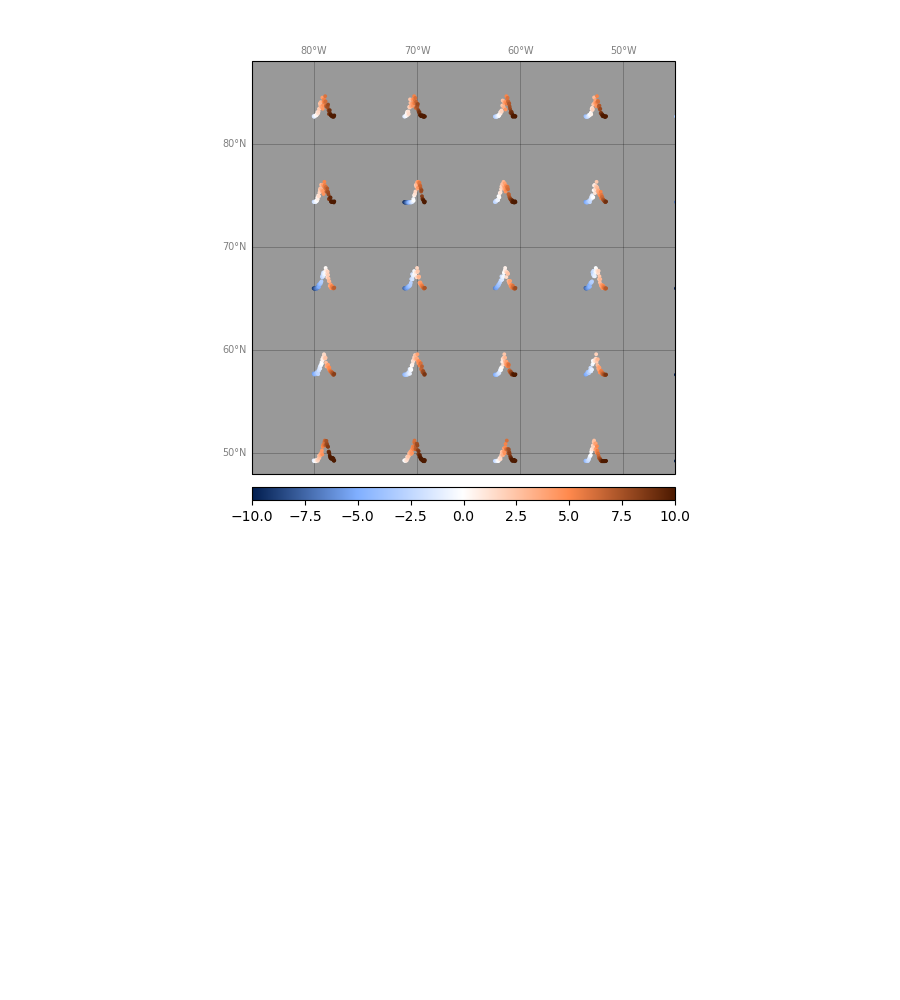

In [25]:
# West Greenland and East Canada
mt_util.plot_global(lat = local_lat, lon = local_lon, data = local_data, limits_data = limits_data,
                cbar_h = 0.03, cbar_mm_factor = 1, unit_transform_n_to_m = False,
                cbar_text = "", figsize=(9,10), coast_width = 0.0,
                bottom=0.5, top=0.95, hspace=0.01, left = 0.28, right = 0.75, extent = [-45, -86, 48, 88],
                title='', point_size=point_size, projection_transformation = "PlateCarree",
                savefig = False, save_dpi = 100, save_string = save_string_local + "_wgreenland",
                save_path = "images/", use_gridlines = True, gridlines_width = 0.4, gridlines_alpha = 0.4,
                data_on_top = True, color_bg = color_bg)